# Mini-Project 1: Modern Low Footprint Cyber Attack Detection

#### Team Members:  1. Harini Madhavaram    2. Keerthi Gudipudi

## Problem Statement:

Software to detect network intrusions protects a computer network from unauthorized users, including
perhaps insiders. This project aims to build a network intrusion detector, a predictive model capable
of distinguishing between bad connections, called intrusions or attacks, and good normal connections.

Use the following models to detect bad
connections (intrusions). Compare the recall, precision and F1-score of the models for attacks and
normal connections, respectively.
PLOT the confusion matrix and ROC curve for each model.

• Logistic Regression • Nearest Neighbor • Support Vector Machine • Fully-Connected Neural Networks  

In [2]:
import numpy as np
import pandas as pd
import os
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from sklearn.svm import SVC
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Helper functions

In [3]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [4]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
trainData = pd.read_csv('UNSW_NB15_training-set_csc215.csv', na_values = "-")
testData = pd.read_csv('UNSW_NB15_test-set_csc215.csv', na_values = "-")

In [6]:
trainData.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,NaN,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,NaN,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,NaN,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,NaN,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [7]:
testData.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,NaN,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,NaN,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,NaN,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,NaN,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,NaN,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [8]:
print(trainData.shape)



(175341, 45)


In [9]:
print(testData.shape)

(82332, 45)


### Check for null values

In [10]:
print(trainData.isnull().sum(axis = 0))


id                       0
dur                      0
proto                    0
service              94168
state                    0
spkts                    0
dpkts                    0
sbytes                   0
dbytes                   0
rate                     0
sttl                     0
dttl                     0
sload                    0
dload                    0
sloss                    0
dloss                    0
sinpkt                   0
dinpkt                   0
sjit                     0
djit                     0
swin                     0
stcpb                    0
dtcpb                    0
dwin                     0
tcprtt                   0
synack                   0
ackdat                   0
smean                    0
dmean                    0
trans_depth              0
response_body_len        0
ct_srv_src               0
ct_state_ttl             0
ct_dst_ltm               0
ct_src_dport_ltm         0
ct_dst_sport_ltm         0
ct_dst_src_ltm           0
i

In [11]:
print(testData.isnull().sum(axis = 0))

id                       0
dur                      0
proto                    0
service              47153
state                    0
spkts                    0
dpkts                    0
sbytes                   0
dbytes                   0
rate                     0
sttl                     0
dttl                     0
sload                    0
dload                    0
sloss                    0
dloss                    0
sinpkt                   0
dinpkt                   0
sjit                     0
djit                     0
swin                     0
stcpb                    0
dtcpb                    0
dwin                     0
tcprtt                   0
synack                   0
ackdat                   0
smean                    0
dmean                    0
trans_depth              0
response_body_len        0
ct_srv_src               0
ct_state_ttl             0
ct_dst_ltm               0
ct_src_dport_ltm         0
ct_dst_sport_ltm         0
ct_dst_src_ltm           0
i

In [12]:
#Serive feature contains maximum no of null values 
trainData = trainData.drop(columns = ['service'])
testData = testData.drop(columns = ['service'])

In [13]:
print(len(trainData.columns))
print(len(testData.columns))

44
44


In [14]:
print(trainData.dtypes)

id                     int64
dur                  float64
proto                 object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_ltm       int64
ct_dst_sport_l

In [15]:
#synack + ackdat = tcprtt
#so drop synack, ackdat because redundant information
trainData = trainData.drop(columns = ["synack", "ackdat"])
testData = testData.drop(columns = ["synack", "ackdat"])

#drop id
trainData = trainData.drop(columns = ["id"])
testData = testData.drop(columns = ["id"])



In [16]:
trainData.shape

(175341, 41)

In [17]:
testData.shape

(82332, 41)

### Drop duplicates


### We have created copy of dataframe for future use.
The Original dataframe will be used for Logistic Regression,KNN and SVM.
Copy of dataframe will be used for Multi Class Classification.

In [18]:
trainData_dup = trainData.drop_duplicates(keep='first', inplace=False)
testData_dup = testData.drop_duplicates(keep='first',inplace=False)


#copy of the dataframe for multi class classification
trainData_dup_copy1 = trainData_dup.copy()
testData_dup_copy1 = testData_dup.copy()

In [18]:
print(trainData_dup.shape)
print(testData_dup.shape)

(107724, 41)
(55940, 41)



#### Normalize using z-score

In [19]:
trainData_dup.dtypes

dur                  float64
proto                 object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_ltm       int64
ct_dst_sport_ltm       int64
ct_dst_src_ltm         int64
is_ftp_login           int64
ct_ftp_cmd    

In [20]:
numerical_features=['dur','spkts','dpkts','sbytes','dbytes','rate','sttl','dttl','sload','dload','sloss','dloss','sinpkt',
                    'dinpkt','sjit','djit','swin','stcpb','dtcpb','dwin','tcprtt','smean','dmean',
                    'trans_depth','response_body_len','ct_srv_src','ct_state_ttl','ct_dst_ltm','ct_src_dport_ltm',
                    'ct_dst_sport_ltm','ct_dst_src_ltm','is_ftp_login','ct_ftp_cmd','ct_flw_http_mthd','ct_src_ltm','ct_srv_dst',
                    'is_sm_ips_ports']

In [21]:
scaler = StandardScaler()
for col in numerical_features:
    trainData_dup[col] = scaler.fit_transform(trainData_dup[[col]])
    testData_dup[col] = scaler.transform(testData_dup[[col]])

<ipython-input-21-d2e1a9847239>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainData_dup[col] = scaler.fit_transform(trainData_dup[[col]])
<ipython-input-21-d2e1a9847239>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData_dup[col] = scaler.transform(testData_dup[[col]])
<ipython-input-21-d2e1a9847239>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

<ipython-input-21-d2e1a9847239>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData_dup[col] = scaler.transform(testData_dup[[col]])
<ipython-input-21-d2e1a9847239>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainData_dup[col] = scaler.fit_transform(trainData_dup[[col]])
<ipython-input-21-d2e1a9847239>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

<ipython-input-21-d2e1a9847239>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainData_dup[col] = scaler.fit_transform(trainData_dup[[col]])
<ipython-input-21-d2e1a9847239>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData_dup[col] = scaler.transform(testData_dup[[col]])
<ipython-input-21-d2e1a9847239>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [22]:
trainData_dup

,dur,proto,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,-0.223587,tcp,FIN,-0.140450,-0.190829,-0.061135,-0.131894,-0.331081,1.010957,1.141270,...,-0.210789,-0.491438,-0.130336,-0.130336,-0.314442,-0.582601,-0.610768,-0.071309,Normal,0
1,-0.127839,tcp,FIN,-0.093864,0.058243,-0.058975,0.102342,-0.331044,-0.751956,1.124031,...,-0.210789,-0.329008,-0.130336,-0.130336,-0.314442,-0.582601,0.195951,-0.071309,Normal,0
2,0.048506,tcp,FIN,-0.128803,-0.102921,-0.060654,-0.059040,-0.331595,-0.751956,1.124031,...,-0.210789,-0.166579,-0.130336,-0.130336,-0.314442,-0.382105,0.195951,-0.071309,Normal,0
3,0.059109,tcp,FIN,-0.105510,-0.132224,-0.059456,-0.128546,-0.331599,-0.751956,1.124031,...,-0.210789,-0.166579,7.397985,7.397985,-0.314442,-0.382105,-0.610768,-0.071309,Normal,0
4,-0.164159,tcp,FIN,-0.117157,-0.176178,-0.059882,-0.131357,-0.331430,1.029514,1.124031,...,-0.210789,5.843306,-0.130336,-0.130336,-0.314442,-0.382105,5.520294,-0.071309,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175267,0.101267,tcp,FIN,0.255531,-0.000362,0.255368,-0.120922,-0.331255,-0.751956,1.124031,...,-0.210789,-0.491438,-0.130336,-0.130336,-0.314442,2.825831,-0.610768,-0.071309,Exploits,1
175277,0.428290,tcp,FIN,0.208945,2.270592,-0.048300,2.254640,-0.330783,-0.751956,1.124031,...,-0.210789,-0.491438,-0.130336,-0.130336,-0.314442,-0.382105,-0.610768,-0.071309,Exploits,1
175299,-0.065036,tcp,FIN,-0.058924,-0.000362,-0.058031,-0.039458,-0.331295,-0.751956,1.124031,...,-0.210789,-0.491438,-0.130336,-0.130336,-0.314442,0.620375,-0.610768,-0.071309,Exploits,1
175305,0.036547,tcp,FIN,-0.012338,-0.058967,-0.005117,-0.121918,-0.331447,-0.751956,1.124031,...,-0.210789,-0.329008,-0.130336,-0.130336,-0.314442,-0.382105,-0.610768,-0.071309,Exploits,1


In [23]:
testData_dup

,dur,proto,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,-0.245596,udp,INT,-0.163743,-0.220132,-0.060055,-0.132857,0.447714,1.029514,-1.048127,...,-0.210789,-0.329008,-0.130336,-0.130336,-0.314442,-0.582601,-0.449424,-0.071309,Normal,0
1,-0.245597,udp,INT,-0.163743,-0.220132,-0.054309,-0.132857,0.740001,1.029514,-1.048127,...,-0.210789,-0.329008,-0.130336,-0.130336,-0.314442,-0.582601,-0.449424,-0.071309,Normal,0
2,-0.245597,udp,INT,-0.163743,-0.220132,-0.057459,-0.132857,1.383032,1.029514,-1.048127,...,-0.210789,-0.166579,-0.130336,-0.130336,-0.314442,-0.582601,-0.288080,-0.071309,Normal,0
3,-0.245597,udp,INT,-0.163743,-0.220132,-0.058221,-0.132857,1.097240,1.029514,-1.048127,...,-0.210789,-0.166579,-0.130336,-0.130336,-0.314442,-0.382105,-0.288080,-0.071309,Normal,0
4,-0.245596,udp,INT,-0.163743,-0.220132,-0.052657,-0.132857,0.525658,1.029514,-1.048127,...,-0.210789,-0.166579,-0.130336,-0.130336,-0.314442,-0.382105,-0.288080,-0.071309,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82319,-0.098483,tcp,FIN,-0.117157,-0.176178,-0.059637,-0.131357,-0.331558,1.029514,1.124031,...,-0.210789,-0.004150,-0.130336,-0.130336,-0.314442,-0.582601,-0.126737,-0.071309,Normal,0
82322,-0.245598,udp,INT,-0.163743,-0.220132,-0.061834,-0.132857,1.811719,1.029514,-1.048127,...,-0.210789,-0.491438,-0.130336,-0.130336,-0.314442,-0.582601,-0.610768,-0.071309,Normal,0
82323,0.690717,tcp,FIN,0.453521,-0.044316,0.564297,-0.127024,-0.331499,1.029514,1.124031,...,-0.210789,-0.491438,-0.130336,-0.130336,-0.314442,-0.582601,-0.288080,-0.071309,Normal,0
82327,-0.245597,udp,INT,-0.163743,-0.220132,-0.061834,-0.132857,1.383032,1.029514,-1.048127,...,-0.210789,-0.329008,-0.130336,-0.130336,-0.314442,-0.382105,-0.610768,-0.071309,Normal,0


#### OneHot Encoding


In [24]:
categorical_features =['proto','state',"attack_cat"]
for col in categorical_features:
    encode_text_dummy(trainData_dup,col)
    encode_text_dummy(testData_dup, col)


<ipython-input-2-cc636c40d077>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dummy_name] = dummies[x]
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [25]:
trainData_dup.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat-Analysis,attack_cat-Backdoor,attack_cat-DoS,attack_cat-Exploits,attack_cat-Fuzzers,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Shellcode,attack_cat-Worms
0,-0.223587,-0.140450,-0.190829,-0.061135,-0.131894,-0.331081,1.010957,1.141270,-0.234937,-0.358622,...,0,0,0,0,0,0,1,0,0,0
1,-0.127839,-0.093864,0.058243,-0.058975,0.102342,-0.331044,-0.751956,1.124031,-0.234965,-0.194362,...,0,0,0,0,0,0,1,0,0,0
2,0.048506,-0.128803,-0.102921,-0.060654,-0.059040,-0.331595,-0.751956,1.124031,-0.234997,-0.341225,...,0,0,0,0,0,0,1,0,0,0
3,0.059109,-0.105510,-0.132224,-0.059456,-0.128546,-0.331599,-0.751956,1.124031,-0.234991,-0.360327,...,0,0,0,0,0,0,1,0,0,0
4,-0.164159,-0.117157,-0.176178,-0.059882,-0.131357,-0.331430,1.029514,1.124031,-0.234964,-0.360118,...,0,0,0,0,0,0,1,0,0,0


In [26]:
testData_dup.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat-Analysis,attack_cat-Backdoor,attack_cat-DoS,attack_cat-Exploits,attack_cat-Fuzzers,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Shellcode,attack_cat-Worms
0,-0.245596,-0.163743,-0.220132,-0.060055,-0.132857,0.447714,1.029514,-1.048127,0.618101,-0.361441,...,0,0,0,0,0,0,1,0,0,0
1,-0.245597,-0.163743,-0.220132,-0.054309,-0.132857,0.740001,1.029514,-1.048127,3.932054,-0.361441,...,0,0,0,0,0,0,1,0,0,0
2,-0.245597,-0.163743,-0.220132,-0.057459,-0.132857,1.383032,1.029514,-1.048127,3.806238,-0.361441,...,0,0,0,0,0,0,1,0,0,0
3,-0.245597,-0.163743,-0.220132,-0.058221,-0.132857,1.097240,1.029514,-1.048127,2.602947,-0.361441,...,0,0,0,0,0,0,1,0,0,0
4,-0.245596,-0.163743,-0.220132,-0.052657,-0.132857,0.525658,1.029514,-1.048127,3.787318,-0.361441,...,0,0,0,0,0,0,1,0,0,0


In [27]:
print(trainData_dup.shape)
print(testData_dup.shape)

(107724, 190)
(55940, 186)


In [28]:
trainExtraColumns = list(set(trainData_dup).difference(testData_dup))

In [29]:
testExtraColumns = list(set(testData_dup).difference(trainData_dup))

In [30]:
trainData_dup.drop(columns = trainExtraColumns, inplace = True)
testData_dup.drop(columns = testExtraColumns, inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
print(trainData_dup.shape)
print(testData_dup.shape)

(107724, 184)
(55940, 184)


In [32]:
#Count of good connections and attack
trainData_dup['label'].value_counts()

1    55834
0    51890
Name: label, dtype: int64

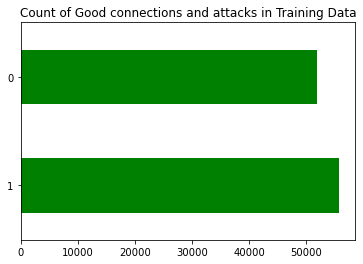

In [33]:
trainData_dup.label.value_counts().plot(kind='barh', title='Count of Good connections and attacks in Training Data',  color='g');
plt.show()

In [34]:
#Count of good connections and attack
testData_dup['label'].value_counts()

0    34204
1    21736
Name: label, dtype: int64

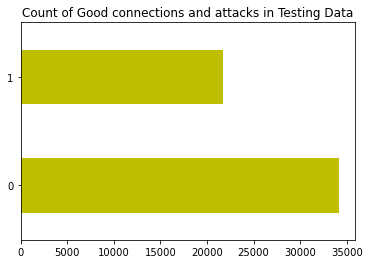

In [35]:
testData_dup.label.value_counts().plot(kind='barh', title='Count of Good connections and attacks in Testing Data',  color='y');
plt.show()

### Split DataFrame X into Y

In [36]:
#copy of the dataframe for NN

trainData_dup_copy = trainData_dup.copy()
testData_dup_copy = testData_dup.copy()


X_train = trainData_dup.drop('label', axis = 1)
y_train = trainData_dup.label

X_test = testData_dup.drop('label', axis = 1)
y_test = testData_dup.label


# Logistic Regression

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34204
           1       1.00      1.00      1.00     21736

    accuracy                           1.00     55940
   macro avg       1.00      1.00      1.00     55940
weighted avg       1.00      1.00      1.00     55940



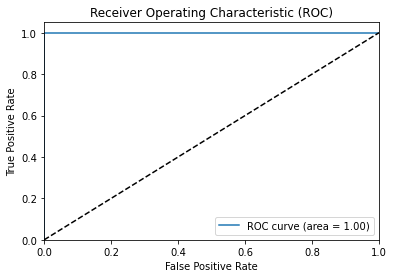

None
[[34204     0]
 [    0 21736]]


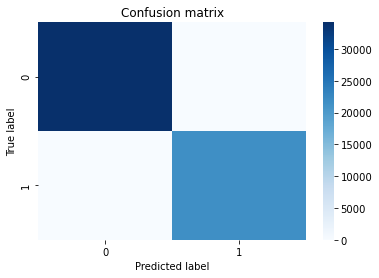

In [37]:
import seaborn as sns

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_pred, y_test))
print(plot_roc(y_pred,y_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)

ax = sns.heatmap(cm, cmap="Blues", yticklabels=True)
ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

In [38]:
#Sort feature importances
importantFeatures = logreg.coef_[0, :].argsort()
importantFeatures = np.array(X_train.columns)[importantFeatures]

attack_cat-Normal is completely predicting the label because attack_cat-Normal == label.
That column is giving a false sense of predicting importance. Better to drop the column to predict it accurately.

182 0.7474258133714694
181 0.8339113335716839
180 0.8822309617447265
179 0.9129245620307472
178 0.9782981766178048
177 0.9782981766178048
176 0.9850554165176976
175 0.9850554165176976
174 0.9930282445477298


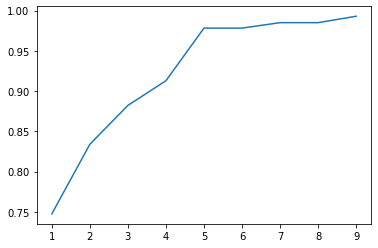

In [39]:

scores = []

for i in range(182, 173, -1):
    impLogReg = LogisticRegression(max_iter = 500)
    impLogReg.fit(X_train.loc[:,importantFeatures[i:184]], y_train)
    newY_pred = impLogReg.predict(X_test.loc[:, importantFeatures[i:184]])
    score = accuracy_score(y_test, newY_pred)
    scores.append(score)
    print(i, score)

plt.plot(range(1, len(scores) + 1), scores)

In [40]:
finalFeatures = importantFeatures[177:]

In [41]:
print("The important features giving 97.8% accuracy are:")
print(finalFeatures)

The important features giving 97.8% accuracy are:
['dttl' 'attack_cat-Generic' 'attack_cat-DoS' 'attack_cat-Reconnaissance'
 'attack_cat-Fuzzers' 'attack_cat-Exploits']


In [42]:
impLogReg = LogisticRegression(max_iter = 500)

impLogReg.fit(X_train.loc[:,finalFeatures], y_train)


LogisticRegression(max_iter=500)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     34204
           1       1.00      0.94      0.97     21736

    accuracy                           0.98     55940
   macro avg       0.98      0.97      0.98     55940
weighted avg       0.98      0.98      0.98     55940



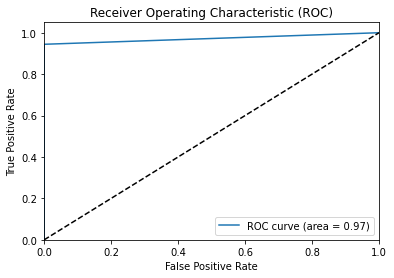

None
[[34204     0]
 [ 1214 20522]]



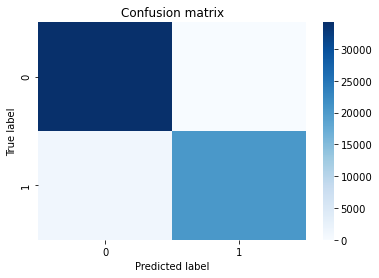

In [43]:
newY_pred = impLogReg.predict(X_test.loc[:, finalFeatures])
print(classification_report(y_test, newY_pred))


print(plot_roc(newY_pred,y_test))

cm = confusion_matrix(y_test, newY_pred)
print(cm)

print()


ax = sns.heatmap(cm, cmap="Blues", yticklabels=True)
ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

# K Nearest Neighbors

In [44]:
#KNN
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [45]:
y_pred_knn = knn.predict(X_test)

In [46]:
print(X_test.shape)
print(X_train.shape)


(55940, 183)
(107724, 183)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     34204
           1       0.97      1.00      0.98     21736

    accuracy                           0.99     55940
   macro avg       0.99      0.99      0.99     55940
weighted avg       0.99      0.99      0.99     55940



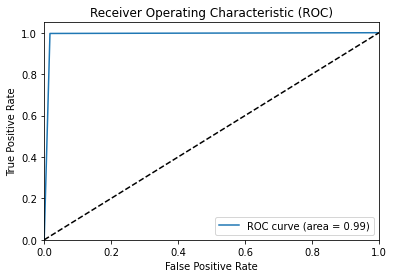

None
[[33615   589]
 [   78 21658]]



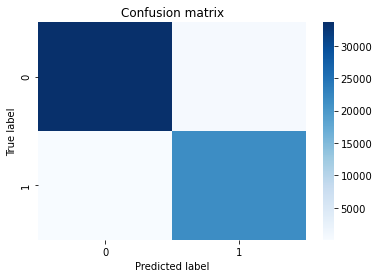

In [47]:
print(classification_report(y_test, y_pred_knn))

print(plot_roc(y_pred_knn,y_test))

cm = confusion_matrix(y_test, y_pred_knn)
print(cm)

print()


ax = sns.heatmap(cm, cmap="Blues", yticklabels=True)
ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()


In [48]:
finalX_train = X_train.loc[:, finalFeatures]
finalX_test = X_test.loc[:, finalFeatures]
knnImp = KNeighborsClassifier(n_neighbors = 5)
knnImp.fit(finalX_train, y_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     34204
           1       1.00      0.94      0.97     21736

    accuracy                           0.98     55940
   macro avg       0.98      0.97      0.98     55940
weighted avg       0.98      0.98      0.98     55940



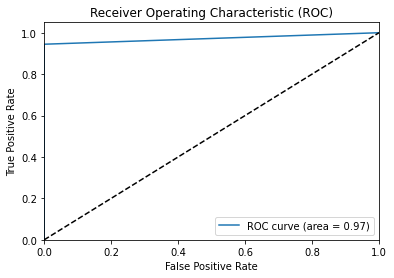

None
[[34203     1]
 [ 1208 20528]]



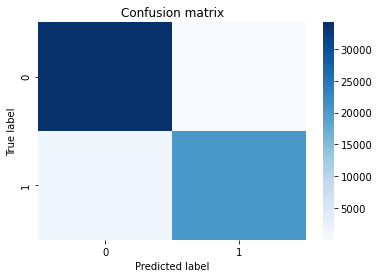

In [49]:
y_pred_new = knnImp.predict(finalX_test)
print(classification_report(y_test, y_pred_new))


print(plot_roc(y_pred_new,y_test))

cm = confusion_matrix(y_test, y_pred_new)
print(cm)

print()


ax = sns.heatmap(cm, cmap="Blues", yticklabels=True)
ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()


# Support Vector Machine


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34204
           1       1.00      1.00      1.00     21736

    accuracy                           1.00     55940
   macro avg       1.00      1.00      1.00     55940
weighted avg       1.00      1.00      1.00     55940



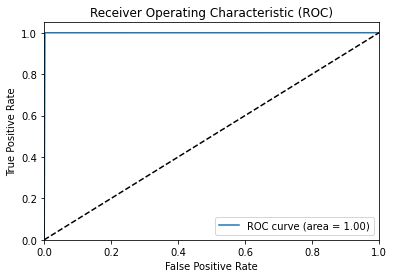

None
[[34131    73]
 [    5 21731]]



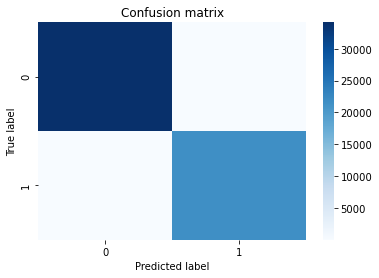

In [50]:
svm = SVC(probability=True)
svm.fit(X_train,y_train)
y_pred_svm = svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

print(plot_roc(y_pred_svm,y_test))

cm = confusion_matrix(y_test, y_pred_svm)
print(cm)

print()


ax = sns.heatmap(cm, cmap="Blues",yticklabels=True)
ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     34204
           1       1.00      0.94      0.97     21736

    accuracy                           0.98     55940
   macro avg       0.98      0.97      0.98     55940
weighted avg       0.98      0.98      0.98     55940



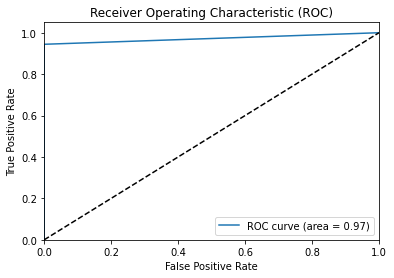

None
[[34204     0]
 [ 1214 20522]]



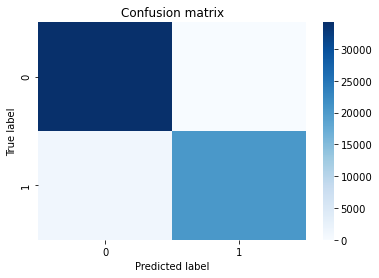

In [51]:
svmImp = SVC(probability=True)
svmImp.fit(X_train.loc[:, finalFeatures],y_train)
y_pred_svm_new = svmImp.predict(X_test.loc[:,finalFeatures])
print(classification_report(y_test, y_pred_svm_new))


print(plot_roc(y_pred_svm_new,y_test))

cm = confusion_matrix(y_test, y_pred_svm_new)
print(cm)

print()


ax = sns.heatmap(cm,cmap="Blues", yticklabels=True)
ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()


# Fully Connected Neural Networks

In [52]:
label = encode_text_index(trainData_dup_copy,"label")
x,y=to_xy(trainData_dup_copy,"label")

In [53]:
label = encode_text_index(testData_dup_copy,"label")
x_test,y_test=to_xy(testData_dup_copy,"label")

# Activation = relu and Optimizer = adam

In [54]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='weight11.hdf5'
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(y.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.fit(x,y,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='min')  
checkpointer = ModelCheckpoint(filepath, verbose=1, save_best_only=True) # save best model

model.fit(x, y, validation_data=(x_test,y_test),epochs=10, callbacks=[monitor,checkpointer], verbose=2)  


model.load_weights(filepath)


Epoch 1/10
3367/3367 - 3s - loss: 0.0180 - accuracy: 0.9951
Epoch 2/10
3367/3367 - 3s - loss: 1.1959e-05 - accuracy: 1.0000
Epoch 3/10
3367/3367 - 4s - loss: 1.4079e-06 - accuracy: 1.0000
Epoch 4/10
3367/3367 - 3s - loss: 7.5248e-04 - accuracy: 0.9998
Epoch 5/10
3367/3367 - 3s - loss: 3.4800e-06 - accuracy: 1.0000
Epoch 6/10
3367/3367 - 3s - loss: 2.2695e-07 - accuracy: 1.0000
Epoch 7/10
3367/3367 - 3s - loss: 7.4525e-08 - accuracy: 1.0000
Epoch 8/10
3367/3367 - 4s - loss: 2.0702e-08 - accuracy: 1.0000
Epoch 9/10
3367/3367 - 4s - loss: 5.3941e-09 - accuracy: 1.0000
Epoch 10/10
3367/3367 - 3s - loss: 1.6822e-09 - accuracy: 1.0000
Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.00011, saving model to weight11.hdf5
3367/3367 - 6s - loss: 6.6186e-10 - accuracy: 1.0000 - val_loss: 1.1362e-04 - val_accuracy: 1.0000
Epoch 2/10

Epoch 00002: val_loss improved from 0.00011 to 0.00011, saving model to weight11.hdf5
3367/3367 - 7s - loss: 3.6973e-10 - accuracy: 1.0000 - val_loss: 1.0815e

In [55]:
pred_nn = model.predict(x_test)
pred_nn

array([[1.0000000e+00, 4.9381993e-10],
       [1.0000000e+00, 5.2748850e-10],
       [1.0000000e+00, 3.3723802e-10],
       ...,
       [1.0000000e+00, 4.7683801e-10],
       [1.0000000e+00, 3.6238371e-10],
       [1.0000000e+00, 7.6657500e-11]], dtype=float32)

In [56]:
pred_nn1 = np.argmax(pred_nn,axis=1)
y_true= np.argmax(y_test,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34204
           1       1.00      1.00      1.00     21736

    accuracy                           1.00     55940
   macro avg       1.00      1.00      1.00     55940
weighted avg       1.00      1.00      1.00     55940



[[34204     0]
 [    1 21735]]
Plotting confusion matrix


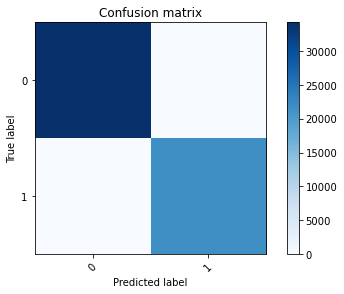

In [57]:

cm = confusion_matrix(y_true, pred_nn1)
print(cm)

print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

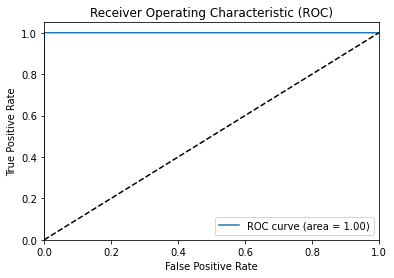

None


In [58]:
print(plot_roc(pred_nn1,y_true))

# Activation = relu and Optimizer = adam with important features from Logistic Regression

In [59]:
y_feature=trainData_dup_copy["label"]
finalFeatures_train=finalFeatures.tolist()
finalFeatures_train = pd.DataFrame(columns = finalFeatures_train) 
#print(testData_top_20) 
for col in finalFeatures_train:
    #df[col].values()+=trainData[col].values()
    finalFeatures_train[col]=trainData_dup_copy[col]
finalFeatures_train = pd.concat([finalFeatures_train, y_feature], axis=1)
finalFeatures_train


,dttl,attack_cat-Generic,attack_cat-DoS,attack_cat-Reconnaissance,attack_cat-Fuzzers,attack_cat-Exploits,label
0,1.141270,0,0,0,0,0,0
1,1.124031,0,0,0,0,0,0
2,1.124031,0,0,0,0,0,0
3,1.124031,0,0,0,0,0,0
4,1.124031,0,0,0,0,0,0
...,...,...,...,...,...,...,...
175267,1.124031,0,0,0,0,1,1
175277,1.124031,0,0,0,0,1,1
175299,1.124031,0,0,0,0,1,1
175305,1.124031,0,0,0,0,1,1


In [60]:
label = encode_text_index(finalFeatures_train,"label")
x_imp,y_imp=to_xy(finalFeatures_train,"label")
x_imp.shape

(107724, 6)

In [61]:
y_test_feature=testData_dup_copy["label"]
finalFeatures_test=finalFeatures.tolist()
finalFeatures_test = pd.DataFrame(columns = finalFeatures) 
#print(testData_top_20) 
for col in finalFeatures_test:
    #df[col].values()+=trainData[col].values()
    finalFeatures_test[col]=testData_dup_copy[col]
finalFeatures_test = pd.concat([finalFeatures_test, y_test_feature], axis=1)
finalFeatures_test

,dttl,attack_cat-Generic,attack_cat-DoS,attack_cat-Reconnaissance,attack_cat-Fuzzers,attack_cat-Exploits,label
0,-1.048127,0,0,0,0,0,0
1,-1.048127,0,0,0,0,0,0
2,-1.048127,0,0,0,0,0,0
3,-1.048127,0,0,0,0,0,0
4,-1.048127,0,0,0,0,0,0
...,...,...,...,...,...,...,...
82319,1.124031,0,0,0,0,0,0
82322,-1.048127,0,0,0,0,0,0
82323,1.124031,0,0,0,0,0,0
82327,-1.048127,0,0,0,0,0,0


In [62]:
label = encode_text_index(finalFeatures_test,"label")
x_test_imp,y_test_imp=to_xy(finalFeatures_test,"label")

In [63]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='weight12.hdf5'
model = Sequential()
model.add(Dense(50, input_dim=x_imp.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(y_imp.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(x_imp,y_imp,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='min')  
checkpointer = ModelCheckpoint(filepath, verbose=1, save_best_only=True) # save best model

model.fit(x_imp, y_imp, validation_data=(x_test_imp,y_test_imp), callbacks=[monitor, checkpointer], verbose=2, epochs=10)  

model.load_weights(filepath)

Epoch 1/10
3367/3367 - 3s - loss: 0.1226
Epoch 2/10
3367/3367 - 3s - loss: 0.0851
Epoch 3/10
3367/3367 - 3s - loss: 0.0843
Epoch 4/10
3367/3367 - 4s - loss: 0.0835
Epoch 5/10
3367/3367 - 5s - loss: 0.0831
Epoch 6/10
3367/3367 - 5s - loss: 0.0819
Epoch 7/10
3367/3367 - 3s - loss: 0.0819
Epoch 8/10
3367/3367 - 3s - loss: 0.0818
Epoch 9/10
3367/3367 - 3s - loss: 0.0818
Epoch 10/10
3367/3367 - 3s - loss: 0.0816
Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.10075, saving model to weight12.hdf5
3367/3367 - 4s - loss: 0.0816 - val_loss: 0.1008
Epoch 2/10

Epoch 00002: val_loss did not improve from 0.10075
3367/3367 - 4s - loss: 0.0815 - val_loss: 0.1038
Epoch 3/10

Epoch 00003: val_loss did not improve from 0.10075
3367/3367 - 4s - loss: 0.0813 - val_loss: 0.1017
Epoch 00003: early stopping


In [64]:
pred_nn_imp = model.predict(x_test_imp)
pred_nn_imp

array([[0.5365504 , 0.46367303],
       [0.5365504 , 0.46367303],
       [0.5365504 , 0.46367303],
       ...,
       [0.8939312 , 0.10718036],
       [0.5365504 , 0.46367303],
       [0.8939312 , 0.10718036]], dtype=float32)

In [65]:
pred_nn1_imp = np.argmax(pred_nn_imp,axis=1)
y_true= np.argmax(y_test_imp,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn1_imp))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     34204
           1       1.00      0.94      0.97     21736

    accuracy                           0.98     55940
   macro avg       0.98      0.97      0.98     55940
weighted avg       0.98      0.98      0.98     55940



[[34204     0]
 [ 1214 20522]]
Plotting confusion matrix


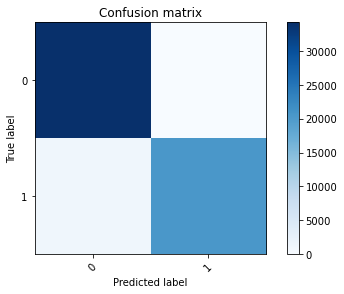

In [66]:
cm = confusion_matrix(y_true, pred_nn1_imp)
print(cm)

print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

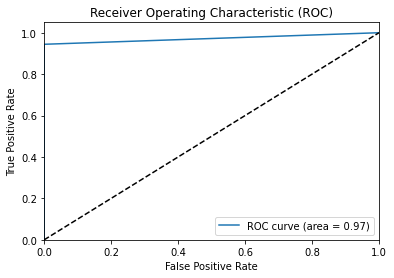

None


In [67]:
print(plot_roc(pred_nn1_imp,y_true))

# Activation = relu and Optimizer = sgd

In [68]:
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(y.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='sgd')

model.fit(x,y,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
checkpointer = ModelCheckpoint(filepath="best_weights21.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x, y, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=10)  

model.load_weights('best_weights21.hdf5')

Epoch 1/10
3367/3367 - 3s - loss: 0.1505
Epoch 2/10
3367/3367 - 3s - loss: 0.0047
Epoch 3/10
3367/3367 - 3s - loss: 0.0019
Epoch 4/10
3367/3367 - 3s - loss: 0.0011
Epoch 5/10
3367/3367 - 3s - loss: 7.8381e-04
Epoch 6/10
3367/3367 - 3s - loss: 5.9337e-04
Epoch 7/10
3367/3367 - 3s - loss: 4.7041e-04
Epoch 8/10
3367/3367 - 3s - loss: 3.8778e-04
Epoch 9/10
3367/3367 - 3s - loss: 3.2702e-04
Epoch 10/10
3367/3367 - 3s - loss: 2.8008e-04
Epoch 1/10
3367/3367 - 4s - loss: 2.4335e-04 - val_loss: 4.6013e-04
Epoch 2/10
3367/3367 - 4s - loss: 2.1532e-04 - val_loss: 4.0799e-04
Epoch 3/10
3367/3367 - 4s - loss: 1.9171e-04 - val_loss: 3.6733e-04
Epoch 00003: early stopping


In [69]:
pred_nn = model.predict(x_test)
pred_nn

array([[9.9865687e-01, 1.0364652e-03],
       [9.9914616e-01, 7.5209141e-04],
       [9.9925804e-01, 6.2456727e-04],
       ...,
       [9.9968427e-01, 5.8022141e-04],
       [9.9741614e-01, 1.9268692e-03],
       [9.9981833e-01, 2.8631091e-04]], dtype=float32)

In [70]:
pred_nn2 = np.argmax(pred_nn,axis=1)
y_true= np.argmax(y_test,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34204
           1       1.00      1.00      1.00     21736

    accuracy                           1.00     55940
   macro avg       1.00      1.00      1.00     55940
weighted avg       1.00      1.00      1.00     55940



[[34204     0]
 [    0 21736]]
Plotting confusion matrix


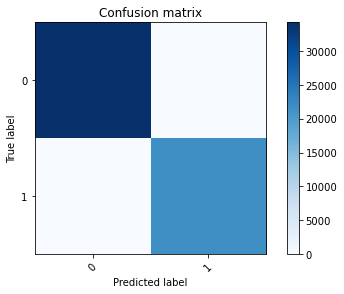

In [71]:
cm = confusion_matrix(y_true, pred_nn2)
print(cm)

print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

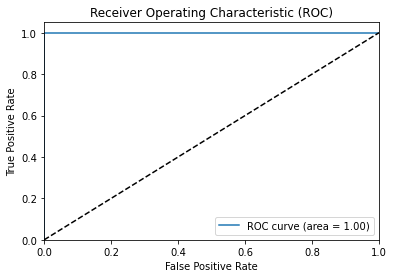

None


In [72]:
print(plot_roc(pred_nn2,y_true))

# Activation = relu and Optimizer = sgd with important features from Logistic Regression

In [73]:
model = Sequential()
model.add(Dense(50, input_dim=x_imp.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(y_imp.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='sgd')

model.fit(x_imp,y_imp,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
checkpointer = ModelCheckpoint(filepath="best_weights22.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_imp, y_imp, validation_data=(x_test_imp,y_test_imp), callbacks=[monitor,checkpointer], verbose=2, epochs=10)  

model.load_weights('best_weights22.hdf5')

Epoch 1/10
3367/3367 - 3s - loss: 0.3868
Epoch 2/10
3367/3367 - 3s - loss: 0.1408
Epoch 3/10
3367/3367 - 3s - loss: 0.1197
Epoch 4/10
3367/3367 - 3s - loss: 0.1024
Epoch 5/10
3367/3367 - 3s - loss: 0.0916
Epoch 6/10
3367/3367 - 3s - loss: 0.0870
Epoch 7/10
3367/3367 - 3s - loss: 0.0851
Epoch 8/10
3367/3367 - 3s - loss: 0.0844
Epoch 9/10
3367/3367 - 3s - loss: 0.0842
Epoch 10/10
3367/3367 - 3s - loss: 0.0839
Epoch 1/10
3367/3367 - 4s - loss: 0.0838 - val_loss: 0.0999
Epoch 2/10
3367/3367 - 4s - loss: 0.0837 - val_loss: 0.1058
Epoch 3/10
3367/3367 - 4s - loss: 0.0837 - val_loss: 0.1095
Epoch 00003: early stopping


In [74]:
pred_nn_imp = model.predict(x_test_imp)
pred_nn_imp

array([[0.56067675, 0.43970126],
       [0.56067675, 0.43970126],
       [0.56067675, 0.43970126],
       ...,
       [0.8907074 , 0.10921133],
       [0.56067675, 0.43970126],
       [0.8907074 , 0.10921133]], dtype=float32)

In [75]:
pred_nn2_imp = np.argmax(pred_nn_imp,axis=1)
y_true= np.argmax(y_test_imp,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn2_imp))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     34204
           1       1.00      0.94      0.97     21736

    accuracy                           0.98     55940
   macro avg       0.98      0.97      0.98     55940
weighted avg       0.98      0.98      0.98     55940



[[34204     0]
 [ 1214 20522]]
Plotting confusion matrix


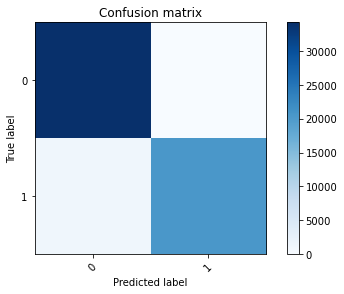

In [76]:
cm = confusion_matrix(y_true, pred_nn2_imp)
print(cm)

print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

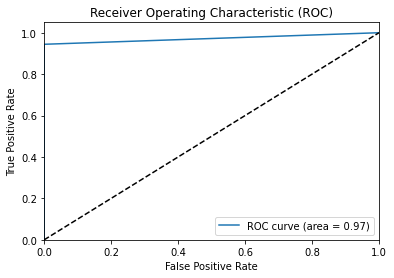

None


In [77]:
print(plot_roc(pred_nn2_imp,y_true))

# Activation = tanh and Optimizer = adam

In [78]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(25, activation='tanh')) # Hidden 2
model.add(Dense(y.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(x,y,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
checkpointer = ModelCheckpoint(filepath="best_weights31.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x, y, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=2, epochs=10)  

model.load_weights('best_weights31.hdf5')


Epoch 1/10
3367/3367 - 3s - loss: 0.0153
Epoch 2/10
3367/3367 - 3s - loss: 3.8049e-04
Epoch 3/10
3367/3367 - 3s - loss: 5.3585e-04
Epoch 4/10
3367/3367 - 3s - loss: 3.9303e-05
Epoch 5/10
3367/3367 - 3s - loss: 3.0733e-06
Epoch 6/10
3367/3367 - 4s - loss: 5.7401e-07
Epoch 7/10
3367/3367 - 3s - loss: 1.0958e-07
Epoch 8/10
3367/3367 - 4s - loss: 2.3690e-08
Epoch 9/10
3367/3367 - 3s - loss: 8.6944e-09
Epoch 10/10
3367/3367 - 3s - loss: 3.8260e-09
Epoch 1/10
3367/3367 - 5s - loss: 2.2377e-09 - val_loss: 1.1033e-04
Epoch 2/10
3367/3367 - 5s - loss: 1.5666e-09 - val_loss: 1.0633e-04
Epoch 3/10
3367/3367 - 5s - loss: 1.2077e-09 - val_loss: 1.0829e-04
Epoch 00003: early stopping


In [79]:
pred_nn = model.predict(x_test)
pred_nn

array([[1.0000000e+00, 1.3291979e-09],
       [1.0000000e+00, 1.3782904e-09],
       [1.0000000e+00, 1.3760340e-09],
       ...,
       [1.0000000e+00, 1.5350652e-09],
       [1.0000000e+00, 1.3478294e-09],
       [1.0000000e+00, 1.3852535e-09]], dtype=float32)

In [80]:
pred_nn3 = np.argmax(pred_nn,axis=1)
y_true= np.argmax(y_test,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34204
           1       1.00      1.00      1.00     21736

    accuracy                           1.00     55940
   macro avg       1.00      1.00      1.00     55940
weighted avg       1.00      1.00      1.00     55940



[[34204     0]
 [    1 21735]]
Plotting confusion matrix


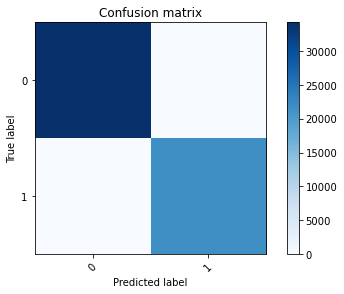

In [81]:
cm = confusion_matrix(y_true, pred_nn3)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

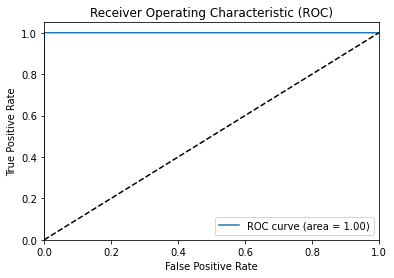

None


In [82]:
print(plot_roc(pred_nn3,y_true))

# Activation = tanh and Optimizer = adam with important features from Logistic Regression

In [83]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
model = Sequential()
model.add(Dense(50, input_dim=x_imp.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(25, activation='tanh')) # Hidden 2
model.add(Dense(y_imp.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(x_imp,y_imp,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
checkpointer = ModelCheckpoint(filepath="best_weights32.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_imp, y_imp, validation_data=(x_test_imp,y_test_imp), callbacks=[monitor, checkpointer], verbose=2, epochs=10)  

model.load_weights('best_weights32.hdf5')


Epoch 1/10
3367/3367 - 3s - loss: 0.1340
Epoch 2/10
3367/3367 - 3s - loss: 0.0869
Epoch 3/10
3367/3367 - 3s - loss: 0.0831
Epoch 4/10
3367/3367 - 3s - loss: 0.0812
Epoch 5/10
3367/3367 - 3s - loss: 0.0806
Epoch 6/10
3367/3367 - 3s - loss: 0.0804
Epoch 7/10
3367/3367 - 3s - loss: 0.0801
Epoch 8/10
3367/3367 - 3s - loss: 0.0800
Epoch 9/10
3367/3367 - 3s - loss: 0.0798
Epoch 10/10
3367/3367 - 3s - loss: 0.0798
Epoch 1/10
3367/3367 - 4s - loss: 0.0797 - val_loss: 0.1043
Epoch 2/10
3367/3367 - 4s - loss: 0.0797 - val_loss: 0.1007
Epoch 3/10
3367/3367 - 4s - loss: 0.0797 - val_loss: 0.1035
Epoch 4/10
3367/3367 - 4s - loss: 0.0797 - val_loss: 0.1044
Epoch 00004: early stopping


In [84]:
pred_nn_imp = model.predict(x_test_imp)
pred_nn_imp

array([[0.61624694, 0.38405198],
       [0.61624694, 0.38405198],
       [0.61624694, 0.38405198],
       ...,
       [0.8571755 , 0.14304939],
       [0.61624694, 0.38405198],
       [0.8571755 , 0.14304939]], dtype=float32)

In [85]:
pred_nn3_imp = np.argmax(pred_nn_imp,axis=1)
y_true= np.argmax(y_test_imp,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn3_imp))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     34204
           1       1.00      0.94      0.97     21736

    accuracy                           0.98     55940
   macro avg       0.98      0.97      0.98     55940
weighted avg       0.98      0.98      0.98     55940



[[34204     0]
 [ 1214 20522]]
Plotting confusion matrix


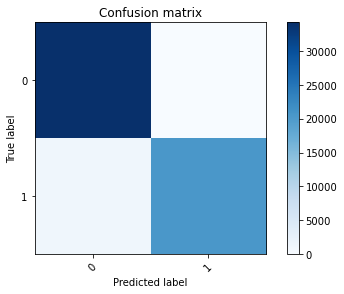

In [86]:
cm = confusion_matrix(y_true, pred_nn3_imp)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

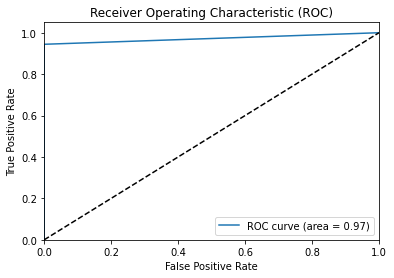

None


In [87]:
print(plot_roc(pred_nn3_imp,y_true))

# Activation = tanh and Optimizer = sgd

In [88]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(25, activation='tanh')) # Hidden 2
model.add(Dense(y.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='sgd')

model.fit(x,y,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
checkpointer = ModelCheckpoint(filepath="best_weights41.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x, y, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=2, epochs=10)  

model.load_weights('best_weights41.hdf5')


Epoch 1/10
3367/3367 - 3s - loss: 0.0888
Epoch 2/10
3367/3367 - 3s - loss: 0.0056
Epoch 3/10
3367/3367 - 3s - loss: 0.0027
Epoch 4/10
3367/3367 - 3s - loss: 0.0017
Epoch 5/10
3367/3367 - 3s - loss: 0.0012
Epoch 6/10
3367/3367 - 3s - loss: 9.5943e-04
Epoch 7/10
3367/3367 - 3s - loss: 7.8161e-04
Epoch 8/10
3367/3367 - 3s - loss: 6.5750e-04
Epoch 9/10
3367/3367 - 3s - loss: 5.6580e-04
Epoch 10/10
3367/3367 - 3s - loss: 4.9667e-04
Epoch 1/10
3367/3367 - 4s - loss: 4.4166e-04 - val_loss: 6.8232e-04
Epoch 2/10
3367/3367 - 4s - loss: 3.9727e-04 - val_loss: 6.2544e-04
Epoch 3/10
3367/3367 - 4s - loss: 3.6073e-04 - val_loss: 5.7633e-04
Epoch 00003: early stopping


In [89]:
pred_nn = model.predict(x_test)
pred_nn

array([[9.9870169e-01, 1.2525022e-03],
       [9.9901360e-01, 1.2734830e-03],
       [9.9905002e-01, 1.1682510e-03],
       ...,
       [9.9898291e-01, 9.3308091e-04],
       [9.9829924e-01, 1.5846789e-03],
       [9.9924666e-01, 6.6733360e-04]], dtype=float32)

In [90]:
pred_nn4 = np.argmax(pred_nn,axis=1)
y_true= np.argmax(y_test,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn4))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34204
           1       1.00      1.00      1.00     21736

    accuracy                           1.00     55940
   macro avg       1.00      1.00      1.00     55940
weighted avg       1.00      1.00      1.00     55940



[[34204     0]
 [    1 21735]]
Plotting confusion matrix


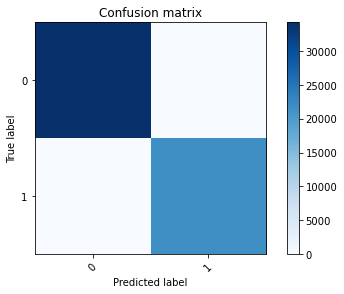

In [91]:
cm = confusion_matrix(y_true, pred_nn4)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

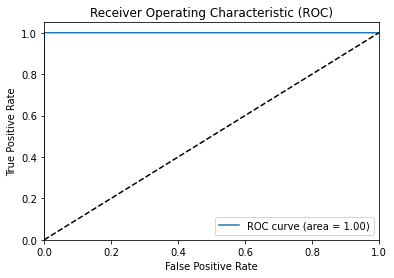

None


In [92]:
print(plot_roc(pred_nn4,y_true))

# Activation = tanh and Optimizer = sgd with important features from Logistic Regression

In [93]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
model = Sequential()
model.add(Dense(50, input_dim=x_imp.shape[1], activation='tanh')) # Hidden 1
model.add(Dense(25, activation='tanh')) # Hidden 2
model.add(Dense(y_imp.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='sgd')

model.fit(x_imp,y_imp,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
checkpointer = ModelCheckpoint(filepath="best_weights42.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_imp, y_imp, validation_data=(x_test_imp,y_test_imp), callbacks=[monitor,checkpointer], verbose=2, epochs=10)  

model.load_weights('best_weights42.hdf5')


Epoch 1/10
3367/3367 - 2s - loss: 0.2817
Epoch 2/10
3367/3367 - 3s - loss: 0.1449
Epoch 3/10
3367/3367 - 3s - loss: 0.1415
Epoch 4/10
3367/3367 - 3s - loss: 0.1384
Epoch 5/10
3367/3367 - 3s - loss: 0.1331
Epoch 6/10
3367/3367 - 3s - loss: 0.1258
Epoch 7/10
3367/3367 - 3s - loss: 0.1170
Epoch 8/10
3367/3367 - 3s - loss: 0.1083
Epoch 9/10
3367/3367 - 3s - loss: 0.1005
Epoch 10/10
3367/3367 - 3s - loss: 0.0949
Epoch 1/10
3367/3367 - 4s - loss: 0.0913 - val_loss: 0.1065
Epoch 2/10
3367/3367 - 4s - loss: 0.0893 - val_loss: 0.1079
Epoch 3/10
3367/3367 - 4s - loss: 0.0880 - val_loss: 0.0954
Epoch 4/10
3367/3367 - 4s - loss: 0.0872 - val_loss: 0.1040
Epoch 5/10
3367/3367 - 4s - loss: 0.0867 - val_loss: 0.0981
Epoch 00005: early stopping


In [94]:
pred_nn_imp = model.predict(x_test_imp)
pred_nn_imp

array([[0.6570659 , 0.34094   ],
       [0.6570659 , 0.34094   ],
       [0.6570659 , 0.34094   ],
       ...,
       [0.8796804 , 0.11888695],
       [0.6570659 , 0.34094   ],
       [0.8796804 , 0.11888695]], dtype=float32)

In [95]:
pred_nn4_imp = np.argmax(pred_nn_imp,axis=1)
y_true= np.argmax(y_test_imp,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn4_imp))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     34204
           1       1.00      0.94      0.97     21736

    accuracy                           0.98     55940
   macro avg       0.98      0.97      0.98     55940
weighted avg       0.98      0.98      0.98     55940



[[34204     0]
 [ 1214 20522]]
Plotting confusion matrix


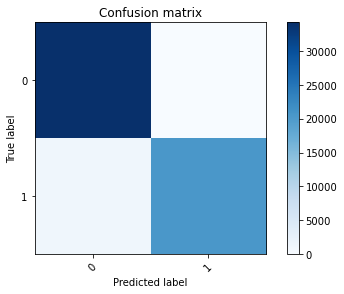

In [96]:
cm = confusion_matrix(y_true, pred_nn4_imp)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

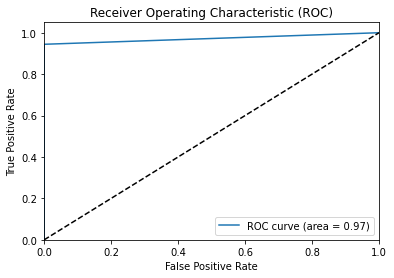

None


In [97]:
print(plot_roc(pred_nn4_imp,y_true))

# Activation = sigmoid and Optimizer = adam by changing layer and neuron counts 

In [98]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
model = Sequential()
model.add(Dense(60, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1
model.add(Dense(30, activation='sigmoid'))# Hidden 2
model.add(Dense(20, activation='sigmoid'))# Hidden 3
model.add(Dense(y.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(x,y,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
checkpointer = ModelCheckpoint(filepath="best_weights31.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x, y, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=2, epochs=10)  

model.load_weights('best_weights31.hdf5')


Epoch 1/10
3367/3367 - 3s - loss: 0.0458
Epoch 2/10
3367/3367 - 3s - loss: 8.8165e-04
Epoch 3/10
3367/3367 - 3s - loss: 3.0060e-04
Epoch 4/10
3367/3367 - 3s - loss: 3.0050e-04
Epoch 5/10
3367/3367 - 3s - loss: 1.2815e-05
Epoch 6/10
3367/3367 - 3s - loss: 2.8444e-06
Epoch 7/10
3367/3367 - 4s - loss: 5.6743e-07
Epoch 8/10
3367/3367 - 4s - loss: 1.1526e-07
Epoch 9/10
3367/3367 - 4s - loss: 2.9720e-08
Epoch 10/10
3367/3367 - 3s - loss: 1.7548e-08
Epoch 1/10
3367/3367 - 5s - loss: 1.4794e-08 - val_loss: 1.4846e-08
Epoch 2/10
3367/3367 - 5s - loss: 1.3641e-08 - val_loss: 1.3726e-08
Epoch 3/10
3367/3367 - 5s - loss: 1.2992e-08 - val_loss: 1.3096e-08
Epoch 00003: early stopping


In [99]:
pred_nn = model.predict(x_test)
pred_nn

array([[1.0000000e+00, 3.1174623e-09],
       [1.0000000e+00, 3.2112477e-09],
       [1.0000000e+00, 3.0685687e-09],
       ...,
       [1.0000000e+00, 3.3900849e-09],
       [1.0000000e+00, 3.0481986e-09],
       [1.0000000e+00, 3.0258909e-09]], dtype=float32)

In [100]:
pred_nn3 = np.argmax(pred_nn,axis=1)
y_true= np.argmax(y_test,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34204
           1       1.00      1.00      1.00     21736

    accuracy                           1.00     55940
   macro avg       1.00      1.00      1.00     55940
weighted avg       1.00      1.00      1.00     55940



[[34204     0]
 [    0 21736]]
Plotting confusion matrix


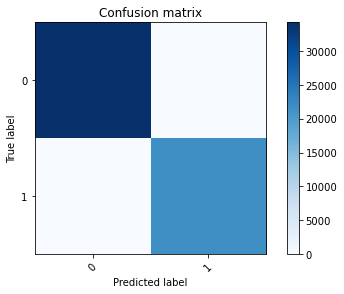

In [101]:
cm = confusion_matrix(y_true, pred_nn3)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

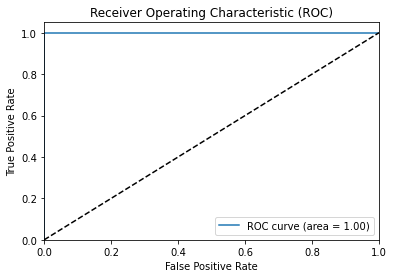

None


In [102]:
print(plot_roc(pred_nn3,y_true))

# Activation = sigmoid and Optimizer = adam with important features from Logistic Regression and by changing layer and neuron counts

In [103]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
model = Sequential()
model.add(Dense(40, input_dim=x_imp.shape[1], activation='sigmoid')) # Hidden 1
model.add(Dense(y_imp.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(x_imp,y_imp,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
checkpointer = ModelCheckpoint(filepath="best_weights32.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_imp, y_imp, validation_data=(x_test_imp,y_test_imp), callbacks=[monitor, checkpointer], verbose=2, epochs=10)  

model.load_weights('best_weights32.hdf5')


Epoch 1/10
3367/3367 - 2s - loss: 0.2458
Epoch 2/10
3367/3367 - 3s - loss: 0.1426
Epoch 3/10
3367/3367 - 10s - loss: 0.1419
Epoch 4/10
3367/3367 - 3s - loss: 0.1416
Epoch 5/10
3367/3367 - 3s - loss: 0.1412
Epoch 6/10
3367/3367 - 3s - loss: 0.1402
Epoch 7/10
3367/3367 - 3s - loss: 0.1380
Epoch 8/10
3367/3367 - 3s - loss: 0.1342
Epoch 9/10
3367/3367 - 3s - loss: 0.1289
Epoch 10/10
3367/3367 - 3s - loss: 0.1225
Epoch 1/10
3367/3367 - 4s - loss: 0.1157 - val_loss: 0.0969
Epoch 2/10
3367/3367 - 4s - loss: 0.1091 - val_loss: 0.0959
Epoch 3/10
3367/3367 - 4s - loss: 0.1031 - val_loss: 0.1092
Epoch 4/10
3367/3367 - 5s - loss: 0.0981 - val_loss: 0.0992
Epoch 00004: early stopping


In [104]:
pred_nn_imp = model.predict(x_test_imp)
pred_nn_imp

array([[0.7841356 , 0.21477813],
       [0.7841356 , 0.21477813],
       [0.7841356 , 0.21477813],
       ...,
       [0.8939578 , 0.10598227],
       [0.7841356 , 0.21477813],
       [0.8939578 , 0.10598227]], dtype=float32)

In [105]:
pred_nn3_imp = np.argmax(pred_nn_imp,axis=1)
y_true= np.argmax(y_test_imp,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn3_imp))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     34204
           1       1.00      0.94      0.97     21736

    accuracy                           0.98     55940
   macro avg       0.98      0.97      0.98     55940
weighted avg       0.98      0.98      0.98     55940



[[34204     0]
 [ 1214 20522]]
Plotting confusion matrix


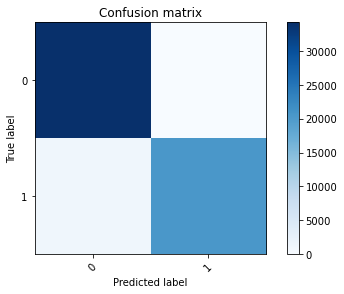

In [106]:
cm = confusion_matrix(y_true, pred_nn3_imp)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

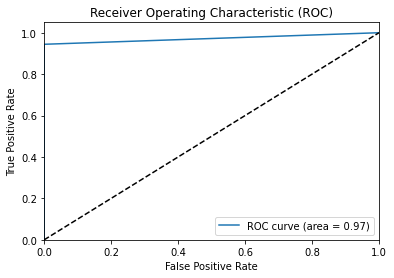

None


In [107]:
print(plot_roc(pred_nn3_imp,y_true))

# Activation = sigmoid and Optimizer = sgd by changing layer and neuron counts

In [108]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1
model.add(Dense(10, activation='sigmoid')) # Hidden 2
model.add(Dense(y.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='sgd')

model.fit(x,y,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
checkpointer = ModelCheckpoint(filepath="best_weights31.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x, y, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=2, epochs=10)  

model.load_weights('best_weights31.hdf5')

Epoch 1/10
3367/3367 - 3s - loss: 0.6543
Epoch 2/10
3367/3367 - 3s - loss: 0.4006
Epoch 3/10
3367/3367 - 3s - loss: 0.1711
Epoch 4/10
3367/3367 - 3s - loss: 0.0650
Epoch 5/10
3367/3367 - 3s - loss: 0.0326
Epoch 6/10
3367/3367 - 3s - loss: 0.0206
Epoch 7/10
3367/3367 - 5s - loss: 0.0147
Epoch 8/10
3367/3367 - 5s - loss: 0.0113
Epoch 9/10
3367/3367 - 4s - loss: 0.0091
Epoch 10/10
3367/3367 - 3s - loss: 0.0076
Epoch 1/10
3367/3367 - 4s - loss: 0.0066 - val_loss: 0.0087
Epoch 2/10
3367/3367 - 4s - loss: 0.0057 - val_loss: 0.0076
Epoch 3/10
3367/3367 - 4s - loss: 0.0051 - val_loss: 0.0067
Epoch 4/10
3367/3367 - 5s - loss: 0.0046 - val_loss: 0.0060
Epoch 5/10
3367/3367 - 6s - loss: 0.0042 - val_loss: 0.0055
Epoch 6/10
3367/3367 - 4s - loss: 0.0038 - val_loss: 0.0050
Epoch 7/10
3367/3367 - 4s - loss: 0.0035 - val_loss: 0.0046
Epoch 8/10
3367/3367 - 4s - loss: 0.0033 - val_loss: 0.0042
Epoch 00008: early stopping


In [109]:
pred_nn = model.predict(x_test)
pred_nn

array([[0.98773265, 0.01212507],
       [0.9892434 , 0.01127243],
       [0.98904717, 0.01137617],
       ...,
       [0.9908709 , 0.00894725],
       [0.98563254, 0.01424202],
       [0.9914906 , 0.00809726]], dtype=float32)

In [110]:
pred_nn3 = np.argmax(pred_nn,axis=1)
y_true= np.argmax(y_test,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34204
           1       1.00      1.00      1.00     21736

    accuracy                           1.00     55940
   macro avg       1.00      1.00      1.00     55940
weighted avg       1.00      1.00      1.00     55940



[[34204     0]
 [    0 21736]]
Plotting confusion matrix


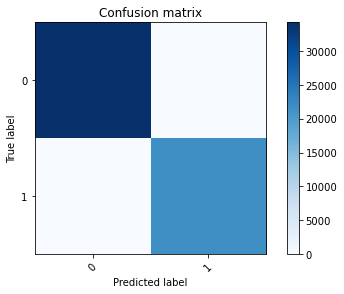

In [111]:
cm = confusion_matrix(y_true, pred_nn3)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

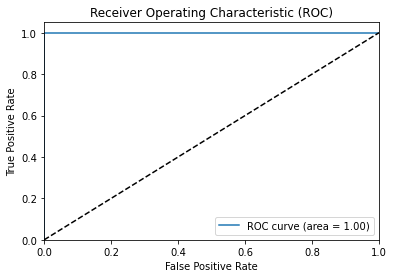

None


In [112]:
print(plot_roc(pred_nn3,y_true))

# Activation = sigmoid and Optimizer = sgd with important features from Logistic Regression and by changing layer and neuron counts

In [113]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
model = Sequential()
model.add(Dense(75, input_dim=x_imp.shape[1], activation='sigmoid')) # Hidden 1
model.add(Dense(50, activation='sigmoid')) # Hidden 2
model.add(Dense(35, activation='sigmoid')) # Hidden 3
model.add(Dense(15, activation='sigmoid')) # Hidden 4
model.add(Dense(y_imp.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='sgd')

model.fit(x_imp,y_imp,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
checkpointer = ModelCheckpoint(filepath="best_weights32.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_imp, y_imp, validation_data=(x_test_imp,y_test_imp), callbacks=[monitor, checkpointer], verbose=2, epochs=10)  

model.load_weights('best_weights32.hdf5')


Epoch 1/10
3367/3367 - 3s - loss: 0.6925
Epoch 2/10
3367/3367 - 3s - loss: 0.6920
Epoch 3/10
3367/3367 - 3s - loss: 0.6915
Epoch 4/10
3367/3367 - 3s - loss: 0.6909
Epoch 5/10
3367/3367 - 5s - loss: 0.6900
Epoch 6/10
3367/3367 - 3s - loss: 0.6887
Epoch 7/10
3367/3367 - 3s - loss: 0.6860
Epoch 8/10
3367/3367 - 4s - loss: 0.6802
Epoch 9/10
3367/3367 - 4s - loss: 0.6628
Epoch 10/10
3367/3367 - 3s - loss: 0.6012
Epoch 1/10
3367/3367 - 4s - loss: 0.5236 - val_loss: 0.6446
Epoch 2/10
3367/3367 - 4s - loss: 0.4493 - val_loss: 0.4704
Epoch 3/10
3367/3367 - 4s - loss: 0.2677 - val_loss: 0.1830
Epoch 4/10
3367/3367 - 4s - loss: 0.1641 - val_loss: 0.1290
Epoch 5/10
3367/3367 - 4s - loss: 0.1491 - val_loss: 0.1131
Epoch 6/10
3367/3367 - 5s - loss: 0.1458 - val_loss: 0.1072
Epoch 7/10
3367/3367 - 4s - loss: 0.1446 - val_loss: 0.1169
Epoch 8/10
3367/3367 - 4s - loss: 0.1439 - val_loss: 0.1069
Epoch 00008: early stopping


In [114]:
pred_nn_imp = model.predict(x_test_imp)
pred_nn_imp

array([[0.9343496 , 0.06555009],
       [0.9343496 , 0.06555009],
       [0.9343496 , 0.06555009],
       ...,
       [0.912004  , 0.08808237],
       [0.9343496 , 0.06555009],
       [0.912004  , 0.08808237]], dtype=float32)

In [115]:
pred_nn3_imp = np.argmax(pred_nn_imp,axis=1)
y_true= np.argmax(y_test_imp,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn3_imp))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     34204
           1       1.00      0.94      0.97     21736

    accuracy                           0.98     55940
   macro avg       0.98      0.97      0.98     55940
weighted avg       0.98      0.98      0.98     55940



[[34204     0]
 [ 1214 20522]]
Plotting confusion matrix


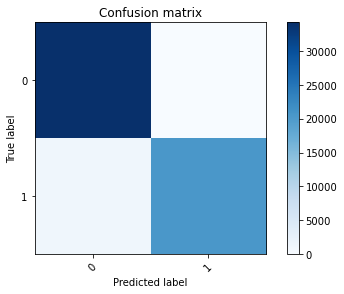

In [116]:
cm = confusion_matrix(y_true, pred_nn3_imp)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

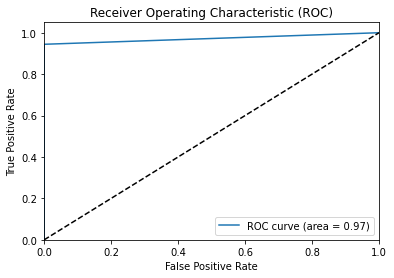

None


In [117]:
print(plot_roc(pred_nn3_imp,y_true))

# Activation = relu and Optimizer = adam with important features from Logistic Regression and by changing layer and neuron counts

In [118]:
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
filepath='weight11.hdf5'
model=Sequential()
model.add(Dense(70, input_dim=x_imp.shape[1], activation='relu')) # Hidden 1
model.add(Dense(30, activation='relu'))# Hidden 2
model.add(Dense(10, activation='relu'))# Hidden 3
model.add(Dense(y_imp.shape[1], activation='sigmoid')) # Output

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.fit(x_imp,y_imp,verbose=2,epochs=10)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='min')  
checkpointer = ModelCheckpoint(filepath, verbose=1, save_best_only=True) # save best model

model.fit(x_imp, y_imp, validation_data=(x_test_imp,y_test_imp),epochs=10, callbacks=[monitor,checkpointer], verbose=2)  


model.load_weights(filepath)


Epoch 1/10
3367/3367 - 3s - loss: 0.1168 - accuracy: 0.9557
Epoch 2/10
3367/3367 - 3s - loss: 0.0850 - accuracy: 0.9583
Epoch 3/10
3367/3367 - 3s - loss: 0.0851 - accuracy: 0.9570
Epoch 4/10
3367/3367 - 5s - loss: 0.0842 - accuracy: 0.9576
Epoch 5/10
3367/3367 - 4s - loss: 0.0829 - accuracy: 0.9580
Epoch 6/10
3367/3367 - 4s - loss: 0.0822 - accuracy: 0.9577
Epoch 7/10
3367/3367 - 4s - loss: 0.0826 - accuracy: 0.9572
Epoch 8/10
3367/3367 - 6s - loss: 0.0816 - accuracy: 0.9577
Epoch 9/10
3367/3367 - 5s - loss: 0.0818 - accuracy: 0.9572
Epoch 10/10
3367/3367 - 4s - loss: 0.0818 - accuracy: 0.9579
Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.09235, saving model to weight11.hdf5
3367/3367 - 7s - loss: 0.0817 - accuracy: 0.9572 - val_loss: 0.0923 - val_accuracy: 0.9783
Epoch 2/10

Epoch 00002: val_loss did not improve from 0.09235
3367/3367 - 7s - loss: 0.0815 - accuracy: 0.9580 - val_loss: 0.1505 - val_accuracy: 0.9167
Epoch 3/10

Epoch 00003: val_loss did not improve from 0.092

In [119]:
pred_nn = model.predict(x_test_imp)
pred_nn

array([[0.6358043 , 0.37303257],
       [0.6358043 , 0.37303257],
       [0.6358043 , 0.37303257],
       ...,
       [0.89040446, 0.11048466],
       [0.6358043 , 0.37303257],
       [0.89040446, 0.11048466]], dtype=float32)

In [120]:
pred_nn1 = np.argmax(pred_nn,axis=1)
y_true= np.argmax(y_test_imp,axis=1) 
from sklearn import metrics
print(metrics.classification_report(y_true, pred_nn1))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     34204
           1       1.00      0.94      0.97     21736

    accuracy                           0.98     55940
   macro avg       0.98      0.97      0.98     55940
weighted avg       0.98      0.98      0.98     55940



[[34204     0]
 [ 1214 20522]]
Plotting confusion matrix


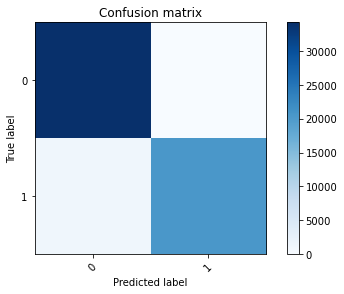

In [121]:
cm = confusion_matrix(y_true, pred_nn1)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, label)
plt.show()

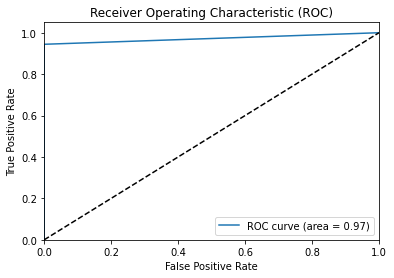

None


In [122]:
print(plot_roc(pred_nn1,y_true))

## ADDITIONAL FEAUTURES


## 1. Multi Class Classification

How good such predictive model can be in terms of detecting each specific attack?



### We already have copies of dataframe trainData_dup_copy1 and testData_dup_copy1

In [19]:
#drop label column as it is not useful in multi class classification
trainData_dup_copy1.drop(columns = ["label"])
testData_dup_copy1.drop(columns = ["label"])


,dur,proto,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.000011,udp,INT,2,0,496,0,90909.090200,254,0,...,1,1,2,0,0,0,1,2,0,Normal
1,0.000008,udp,INT,2,0,1762,0,125000.000300,254,0,...,1,1,2,0,0,0,1,2,0,Normal
2,0.000005,udp,INT,2,0,1068,0,200000.005100,254,0,...,1,1,3,0,0,0,1,3,0,Normal
3,0.000006,udp,INT,2,0,900,0,166666.660800,254,0,...,2,1,3,0,0,0,2,3,0,Normal
4,0.000010,udp,INT,2,0,2126,0,100000.002500,254,0,...,2,1,3,0,0,0,2,3,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82319,0.811914,tcp,FIN,10,6,588,268,18.474862,254,252,...,1,1,4,0,0,0,1,4,0,Normal
82322,0.000004,udp,INT,2,0,104,0,250000.000600,254,0,...,1,1,1,0,0,0,1,1,0,Normal
82323,5.167410,tcp,FIN,108,24,138067,1042,25.351192,254,252,...,1,1,1,0,0,0,1,3,0,Normal
82327,0.000005,udp,INT,2,0,104,0,200000.005100,254,0,...,1,1,2,0,0,0,2,1,0,Normal


In [20]:
numerical_features=['dur','spkts','dpkts','sbytes','dbytes','rate','sttl','dttl','sload','dload','sloss','dloss','sinpkt',
                    'dinpkt','sjit','djit','swin','stcpb','dtcpb','dwin','tcprtt','smean','dmean',
                    'trans_depth','response_body_len','ct_srv_src','ct_state_ttl','ct_dst_ltm','ct_src_dport_ltm',
                    'ct_dst_sport_ltm','ct_dst_src_ltm','is_ftp_login','ct_ftp_cmd','ct_flw_http_mthd','ct_src_ltm','ct_srv_dst',
                    'is_sm_ips_ports']

In [21]:
scaler = StandardScaler()
for col in numerical_features:
    trainData_dup_copy1[col] = scaler.fit_transform(trainData_dup_copy1[[col]])
    testData_dup_copy1[col] = scaler.transform(testData_dup_copy1[[col]])

In [22]:
object_features =['proto','state']
for col in object_features:
    encode_text_dummy(trainData_dup_copy1, col)
    encode_text_dummy(testData_dup_copy1, col)

In [23]:
print(len(trainData_dup_copy1.columns))
print(len(testData_dup_copy1.columns))

181
177


In [24]:
trainExtraColumns = list(set(trainData_dup_copy1).difference(testData_dup_copy1))
testExtraColumns = list(set(testData_dup_copy1).difference(trainData_dup_copy1))
trainData_dup_copy1.drop(columns = trainExtraColumns, inplace = True)
testData_dup_copy1.drop(columns = testExtraColumns, inplace = True)

In [25]:
trainData_dup_copy1.isnull().sum()

dur          0
spkts        0
dpkts        0
sbytes       0
dbytes       0
            ..
state-CON    0
state-FIN    0
state-INT    0
state-REQ    0
state-RST    0
Length: 175, dtype: int64

In [26]:
testData_dup_copy1.isnull().sum()

dur          0
spkts        0
dpkts        0
sbytes       0
dbytes       0
            ..
state-CON    0
state-FIN    0
state-INT    0
state-REQ    0
state-RST    0
Length: 175, dtype: int64

In [27]:
y_train_multi = trainData_dup_copy1["attack_cat"]
X_train_multi=  trainData_dup_copy1.drop(columns = ["attack_cat"])
y_test_multi = testData_dup_copy1["attack_cat"]
X_test_multi=  testData_dup_copy1.drop(columns = ["attack_cat"])

In [28]:
print(X_train_multi.shape)
print(y_train_multi.shape)
print(X_test_multi.shape)
print(y_test_multi.shape)

(107724, 174)
(107724,)
(55940, 174)
(55940,)


In [29]:
newlabel_multi_train = pd.DataFrame(y_train_multi, columns = ['attack_cat'])
print(newlabel_multi_train)

newlabel_multi_test = pd.DataFrame(y_test_multi, columns = ['attack_cat'])
print(newlabel_multi_test)

       attack_cat
0          Normal
1          Normal
2          Normal
3          Normal
4          Normal
...           ...
175267   Exploits
175277   Exploits
175299   Exploits
175305   Exploits
175337  Shellcode

[107724 rows x 1 columns]
      attack_cat
0         Normal
1         Normal
2         Normal
3         Normal
4         Normal
...          ...
82319     Normal
82322     Normal
82323     Normal
82327     Normal
82328     Normal

[55940 rows x 1 columns]


In [30]:
newlabel_multi_train['attack_cat'].value_counts()

Normal            51890
Exploits          19836
Fuzzers           16147
Reconnaissance     7522
Generic            4181
DoS                3801
Analysis           1594
Backdoor           1535
Shellcode          1091
Worms               127
Name: attack_cat, dtype: int64

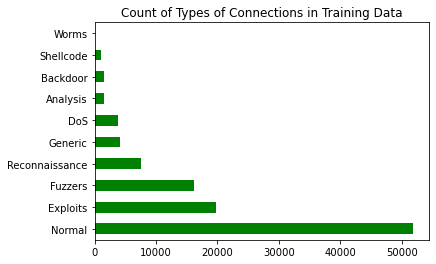

In [31]:
newlabel_multi_train.attack_cat.value_counts().plot(kind='barh', title='Count of Types of Connections in Training Data',  color='g');
plt.show()

In [32]:
newlabel_multi_test['attack_cat'].value_counts()

Normal            34204
Exploits           7607
Fuzzers            4838
Generic            3657
Reconnaissance     2703
DoS                1717
Analysis            446
Shellcode           378
Backdoor            346
Worms                44
Name: attack_cat, dtype: int64

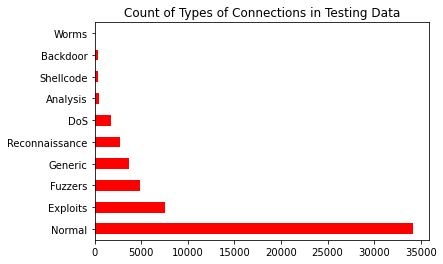

In [33]:
newlabel_multi_test.attack_cat.value_counts().plot(kind='barh', title='Count of Types of Connections in Testing Data',  color='r');
plt.show()

## Logistic regression

In [34]:
logre = LogisticRegression(max_iter=1500)
logre.fit(X_train_multi, y_train_multi)
y_pred = logre.predict(X_test_multi)
print(classification_report(y_pred, y_test_multi))

                precision    recall  f1-score   support

      Analysis       0.25      0.16      0.19       710
      Backdoor       0.00      0.02      0.01        54
           DoS       0.02      0.47      0.04        72
      Exploits       0.78      0.75      0.76      7863
       Fuzzers       0.87      0.57      0.69      7420
       Generic       0.61      0.89      0.72      2489
        Normal       1.00      1.00      1.00     34194
Reconnaissance       0.65      0.57      0.60      3090
     Shellcode       0.07      0.60      0.12        43
         Worms       0.00      0.00      0.00         5

      accuracy                           0.87     55940
     macro avg       0.42      0.50      0.41     55940
  weighted avg       0.90      0.87      0.88     55940



[[  111    92   147   155   143     5     1    56     0     0]
 [    7     1    13    12     9     2     0    10     0     0]
 [    6     3    34    14     6     4     0     5     0     0]
 [   95    56   883  5905   135   383     0   368     8    30]
 [  136   113   375  1097  4202   844     0   512   128    13]
 [   48    47    51    79    48  2214     0     2     0     0]
 [    0     0     0     0     0     0 34194     0     0     0]
 [   43    34   212   339   294   201     0  1750   216     1]
 [    0     0     2     3     1     2     9     0    26     0]
 [    0     0     0     3     0     2     0     0     0     0]]



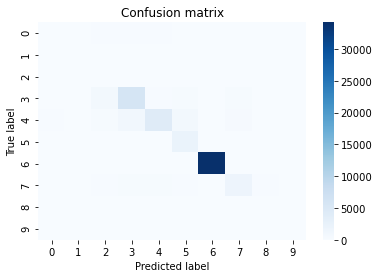

In [35]:
cm = confusion_matrix(y_pred, y_test_multi)
print(cm)
print()
import seaborn as sns
ax = sns.heatmap(cm, cmap="Blues", yticklabels=True)
ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

## K Nearest Neighbor

In [36]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_multi, y_train_multi)
y_pred_knn_multi = knn.predict(X_test_multi)

                precision    recall  f1-score   support

      Analysis       0.45      0.14      0.21      1466
      Backdoor       0.16      0.07      0.09       811
           DoS       0.11      0.34      0.16       534
      Exploits       0.77      0.75      0.76      7773
       Fuzzers       0.79      0.60      0.68      6424
       Generic       0.64      0.91      0.75      2573
        Normal       0.97      1.00      0.99     33362
Reconnaissance       0.63      0.60      0.61      2802
     Shellcode       0.24      0.48      0.32       191
         Worms       0.09      1.00      0.17         4

      accuracy                           0.85     55940
     macro avg       0.48      0.59      0.47     55940
  weighted avg       0.85      0.85      0.85     55940

[[  199   165   280   292   258    24   123   125     0     0]
 [  119    54   172   173   157     8     3   125     0     0]
 [    8     7   181   211    19    46    23    21    16     2]
 [   48    16   739  584

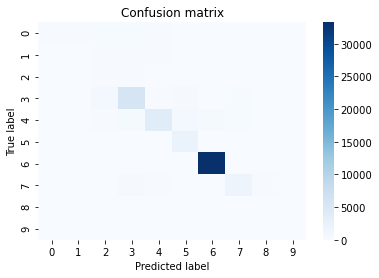

In [37]:
print(classification_report(y_pred_knn_multi, y_test_multi))
cm = confusion_matrix(y_pred_knn_multi, y_test_multi)
print(cm)
print()
import seaborn as sns
ax = sns.heatmap(cm, cmap="Blues", yticklabels=True)
ax.set_title('Confusion matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

### 2. Training the model with selected features

Among all the features, can you identify the most important features (this is so called feature importance analysis) and train models only on those important features, e.g., top-10 most important features? What would be the benefits to do that? 

We have trained all the models with selected features after training the model with all the features.